In [1]:
from scipy.io import wavfile as wv
import scipy.signal as ss
from scipy.stats import entropy
import scipy
import numpy as np
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import sklearn.naive_bayes as sknb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

In [31]:
training_data = pd.read_csv('train.csv')
labels = training_data['Genre'].values
unique_labels = []

In [3]:
# Directory to my test set should change
directory_test = "test"

audio_data_list_test = []
sampling_rate_list_test = []

# Iterate over test data
for filename in os.listdir(directory_test):
    # Loads all the .wav files in the test set
    if filename.endswith(".wav"):
        file_path = os.path.join(directory_test, filename)
        audio_data, sampling_rate = librosa.load(file_path, sr=None)
        
        # Append the audio data and sampling rate to the lists
        audio_data_list_test.append(audio_data)
        sampling_rate_list_test.append(sampling_rate)

# Now we can use the audio data and sampling rate data

In [21]:
# Directory to my training set should change
directory = "train"

audio_data_list_unsorted = []
sampling_rate_list_unsorted = []

filename_list_unsorted = []

# Iterate over training data
for filename in os.listdir(directory):
    # Loads all the .wav files in the training set
    if filename.endswith(".wav"):
        file_path = os.path.join(directory, filename)
        audio_data, sampling_rate = librosa.load(file_path, sr=None)
        
        # Append the audio data and sampling rate to the lists
        audio_data_list_unsorted.append(audio_data)
        sampling_rate_list_unsorted.append(sampling_rate)

        filename_list_unsorted.append(filename)

# here, we sort normalized_features so our y data matches it
zipped_lists = zip(filename_list_unsorted, audio_data_list_unsorted, sampling_rate_list_unsorted)
zipped_sorted = sorted(zipped_lists, key=lambda x: x[0][5:8])
audio_data_list = [x for _, x, _ in zipped_sorted]
sampling_rate_list = [x for _, _, x in zipped_sorted]
filename_list = [x for x, _, _ in zipped_sorted]



# Now we can use the audio data and sampling rate data

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


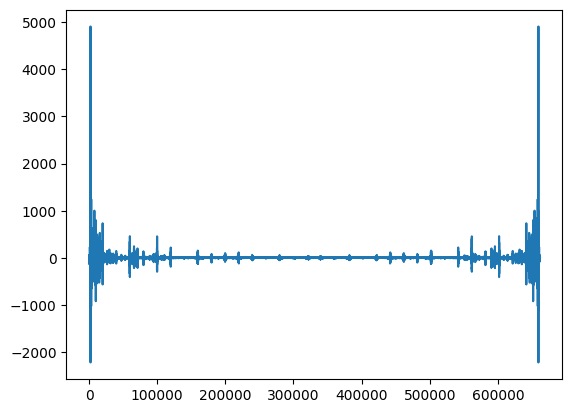

In [6]:
#Gathers the frequency information of a song
fft_list = []
for song in audio_data_list:
    fft_list.append(np.fft.fft(song))
    
fft_list_test = []
for song in audio_data_list_test:
    fft_list_test.append(np.fft.fft(song))
plt.plot(fft_list_test[0])

In [7]:
# Computes energy of each song
energy_list = []
for song in audio_data_list:
    energy_list.append(np.sum(np.square(song)))
    
energy_list_test = []
for song in audio_data_list_test:
    energy_list_test.append(np.sum(np.square(song)))

In [8]:
# Finds the variance and mean of each song
variance_list = []
expectation_list = []
for song in audio_data_list:
    variance_list.append(np.var(song))
    expectation_list.append(np.mean(song))
    
variance_list_test = []
expectation_list_test = []
for song in audio_data_list_test:
    variance_list_test.append(np.var(song))
    expectation_list_test.append(np.mean(song))

In [11]:
tempo_list = []
for i in range(0,len(audio_data_list)):
    tempo, _ = librosa.beat.beat_track(y=audio_data_list[i], sr=sampling_rate_list[i])
    tempo_list.append(tempo)

tempo_list_test = []
for i in range(0,len(audio_data_list_test)):
    tempo, _ = librosa.beat.beat_track(y=audio_data_list_test[i], sr=sampling_rate_list_test[i])
    tempo_list_test.append(tempo)
print(tempo_list)
print(tempo_list_test)


[107.666015625, 161.4990234375, 73.828125, 161.4990234375, 129.19921875, 78.30255681818181, 95.703125, 161.4990234375, 117.45383522727273, 143.5546875, 78.30255681818181, 172.265625, 99.38401442307692, 78.30255681818181, 80.74951171875, 117.45383522727273, 107.666015625, 123.046875, 107.666015625, 161.4990234375, 95.703125, 123.046875, 151.99908088235293, 123.046875, 172.265625, 112.34714673913044, 129.19921875, 123.046875, 161.4990234375, 95.703125, 135.99917763157896, 161.4990234375, 184.5703125, 89.10290948275862, 112.34714673913044, 95.703125, 80.74951171875, 184.5703125, 99.38401442307692, 107.666015625, 117.45383522727273, 123.046875, 103.359375, 161.4990234375, 80.74951171875, 112.34714673913044, 86.1328125, 143.5546875, 107.666015625, 129.19921875, 129.19921875, 123.046875, 143.5546875, 83.35433467741936, 95.703125, 103.359375, 66.25600961538461, 95.703125, 117.45383522727273, 135.99917763157896, 107.666015625, 143.5546875, 135.99917763157896, 129.19921875, 184.5703125, 172.265

In [12]:
zero_cross_rate_list = []
for song in audio_data_list:
    zero_cross_rate_list.append(np.median(librosa.feature.zero_crossing_rate(song)))

zero_cross_rate_list_test = []
for song in audio_data_list_test:
    zero_cross_rate_list_test.append(np.median(librosa.feature.zero_crossing_rate(song)))

print(zero_cross_rate_list)
print(zero_cross_rate_list_test)

[0.08203125, 0.07177734375, 0.05126953125, 0.06640625, 0.09765625, 0.14599609375, 0.07177734375, 0.0693359375, 0.052734375, 0.07080078125, 0.12158203125, 0.09423828125, 0.07080078125, 0.1171875, 0.0712890625, 0.05810546875, 0.13671875, 0.11376953125, 0.1044921875, 0.12548828125, 0.16943359375, 0.14306640625, 0.0859375, 0.1298828125, 0.06591796875, 0.05517578125, 0.0654296875, 0.03271484375, 0.060546875, 0.1328125, 0.126953125, 0.10302734375, 0.0849609375, 0.0390625, 0.1611328125, 0.0576171875, 0.037109375, 0.0595703125, 0.0380859375, 0.1318359375, 0.1318359375, 0.10400390625, 0.11962890625, 0.05029296875, 0.087890625, 0.20166015625, 0.14892578125, 0.1259765625, 0.07666015625, 0.11279296875, 0.15087890625, 0.11083984375, 0.0517578125, 0.09619140625, 0.1103515625, 0.0458984375, 0.0380859375, 0.1005859375, 0.1044921875, 0.12841796875, 0.1640625, 0.04931640625, 0.06689453125, 0.1669921875, 0.13134765625, 0.12158203125, 0.0947265625, 0.16943359375, 0.090087890625, 0.06787109375, 0.070800781

In [13]:
fft_entrp_list = []
for fft in fft_list:
    fft_entrp_list.append(entropy(np.absolute(fft)))

fft_entrp_list_test = []
for fft in fft_list_test:
    fft_entrp_list_test.append(entropy(np.absolute(fft)))

In [14]:
fft_mean_list = []
for fft in fft_list:
    fft_mean_list.append(np.average(np.absolute(fft)))

fft_mean_list_test = []
for fft in fft_list_test:
    fft_mean_list_test.append(np.average(np.absolute(fft)))

In [15]:
fft_var_list = []
for fft in fft_list:
    fft_var_list.append(np.var(fft))

fft_var_list_test = []
for fft in fft_list_test:
    fft_var_list_test.append(np.var(fft))

In [16]:
mfcc_list = []
for song in audio_data_list:
    mfcc_list.append(librosa.feature.mfcc(y = song, n_mfcc = 15))

mfcc_list_test = []
for song in audio_data_list_test:
    mfcc_list_test.append(librosa.feature.mfcc(y = song, n_mfcc = 15))

In [ ]:
condensed_mfcc = []
for mfcc in mfcc_list:
    condensed_mfcc.append(np.average(mfcc))

condensed_mfcc_test = []
for mfcc in mfcc_list_test:
    condensed_mfcc_test.append(np.average(mfcc))

In [24]:
var_mfcc = []
for mfcc in mfcc_list:
    var_mfcc.append(np.var(mfcc))

var_mfcc_test = []
for mfcc in mfcc_list_test:
    var_mfcc_test.append(np.var(mfcc))

In [25]:
spectral_centroid_list = []
spectral_rolloff_list = []
spectral_bandwidth_list = []
spectral_contrast_list = []
spectral_flatness_list = []
onset_list = []
beat_list = []
beat_eng_list = []
chrom_list = []
for song in audio_data_list:
    spectral_centroid_list.append(librosa.feature.spectral_centroid(y = song))
    spectral_rolloff_list.append(librosa.feature.spectral_rolloff(y = song))
    spectral_flatness_list.append(librosa.feature.spectral_flatness(y = song))
    onset = librosa.onset.onset_strength(y = song)
    onset_list.append(onset)
    _, beat = librosa.beat.beat_track(y = song)
    beat_list.append(beat)
    beat_eng_list.append(onset[beat])
    chrom_list.append(librosa.feature.chroma_stft(y = song))
    spectral_bandwidth_list.append(librosa.feature.spectral_bandwidth(y = song))
    spectral_contrast_list.append(librosa.feature.spectral_contrast(y = song))



KeyboardInterrupt: 

In [38]:
spectral_centroid_list_mean = []
for song in audio_data_list:
    # librosa.feature.spectral_centroid returns an array of spectral centroids of frames throughout signal, take the mean of that array to get average COM of signal
    spectral_centroid_list_mean.append(np.mean(librosa.feature.spectral_centroid(y=song)))

#Get the unique labels
unique_labels = np.unique(labels)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Getting a colormap from matplotlib
print(color_map)
label_to_unique_color = {label: color_map(i) for i, label in enumerate(unique_labels)}
print(label_to_unique_color)

# Plot each mean spectral centroid with its label color
for i, (centroid_mean, label) in enumerate(zip(spectral_centroid_list_mean[0:25], labels[0:25])):
    plt.scatter(i,  # X-axis: index of the song
                centroid_mean,  # Y-axis: mean spectral centroid
                color=label_to_unique_color[label],  # Color corresponding to the label
                alpha=0.5)  # Semi-transparent points

# To avoid duplicate labels in the legend, we collect label-color pairs
# and plot dummy points to create the legend
for label, color in label_to_unique_color.items():
    plt.scatter([], [], color=color, label=label)

plt.legend()

plt.xlabel('Song Index')
plt.ylabel('Mean Spectral Centroid')
plt.title('Mean Spectral Centroids by Genre')
plt.show()

/var/folders/5z/n0hvm0bn3t9bnpdyw3yvxpsr0000gn/T/ipykernel_1113/2498588085.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Getting a colormap from matplotlib


{'blues': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'classical': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'country': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'disco': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'hiphop': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 'jazz': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'metal': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'pop': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 'reggae': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 'rock': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)}


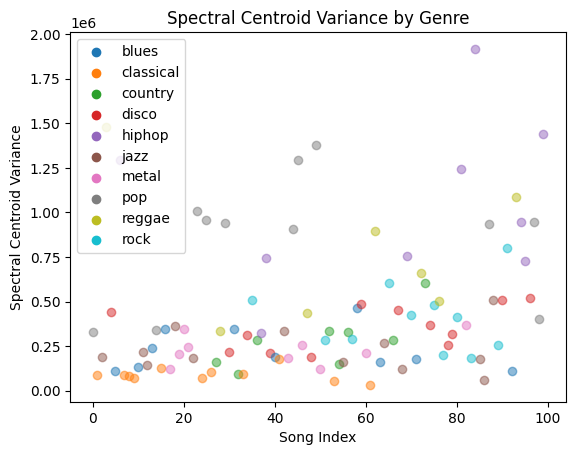

In [41]:
spectral_centroid_list_var = []
for song in audio_data_list:
    # librosa.feature.spectral_centroid returns an array of spectral centroids of frames throughout signal, take the mean of that array to get average COM of signal
    spectral_centroid_list_var.append(np.var(librosa.feature.spectral_centroid(y=song)))

#Get the unique labels
unique_labels = np.unique(labels)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Getting a colormap from matplotlib
print(color_map)
label_to_unique_color = {label: color_map(i) for i, label in enumerate(unique_labels)}
print(label_to_unique_color)

# Plot each mean spectral centroid with its label color
for i, (centroid_var, label) in enumerate(zip(spectral_centroid_list_var[0:100], labels[0:100])):
    plt.scatter(i,  # X-axis: index of the song
                centroid_var,  # Y-axis: mean spectral centroid
                color=label_to_unique_color[label],  # Color corresponding to the label
                alpha=0.5)  # Semi-transparent points

# To avoid duplicate labels in the legend, we collect label-color pairs
# and plot dummy points to create the legend
for label, color in label_to_unique_color.items():
    plt.scatter([], [], color=color, label=label)

plt.legend()

plt.xlabel('Song Index')
plt.ylabel('Spectral Centroid Variance')
plt.title('Spectral Centroid Variance by Genre')
plt.show()

In [42]:
beat_list = []
for song in audio_data_list:
    _, beat = librosa.beat.beat_track(y = song)
    beat_list.append(beat)

[array([   4,   28,   53,   78,  102,  126,  151,  176,  200,  224,  249,
        273,  298,  322,  347,  371,  396,  420,  445,  469,  493,  518,
        543,  567,  591,  616,  641,  665,  689,  714,  739,  763,  787,
        812,  837,  861,  885,  910,  934,  959,  983, 1008, 1033, 1057,
       1081, 1106, 1130, 1151, 1174, 1197, 1216, 1241, 1265]), array([  18,   34,   52,   68,   84,  100,  116,  133,  151,  167,  183,
        200,  216,  232,  248,  264,  280,  296,  312,  327,  343,  359,
        375,  391,  407,  423,  439,  455,  471,  486,  502,  518,  533,
        549,  565,  580,  596,  611,  628,  645,  662,  680,  696,  712,
        729,  746,  763,  780,  796,  812,  827,  842,  858,  875,  891,
        907,  924,  941,  958,  975,  991, 1007, 1023, 1039, 1055, 1071,
       1087, 1103, 1119, 1135, 1151, 1167, 1183, 1198, 1215, 1231, 1247]), array([   6,   42,   77,  112,  148,  184,  218,  254,  288,  324,  360,
        395,  430,  466,  498,  537,  569,  606,  639,  67

In [ ]:
spectral_centroid_list = []
spectral_rolloff_list = []
spectral_bandwidth_list = []
spectral_contrast_list = []
spectral_flatness_list = []
onset_list = []
beat_list = []
beat_eng_list = []
chrom_list = []
for song in audio_data_list:
    spectral_centroid_list.append(librosa.feature.spectral_centroid(y = song))
    spectral_rolloff_list.append(librosa.feature.spectral_rolloff(y = song))
    spectral_flatness_list.append(librosa.feature.spectral_flatness(y = song))
    onset = librosa.onset.onset_strength(y = song)
    onset_list.append(onset)
    _, beat = librosa.beat.beat_track(y = song)
    beat_list.append(beat)
    beat_eng_list.append(onset[beat])
    chrom_list.append(librosa.feature.chroma_stft(y = song))
    spectral_bandwidth_list.append(librosa.feature.spectral_bandwidth(y = song))
    spectral_contrast_list.append(librosa.feature.spectral_contrast(y = song))


In [ ]:
spectral_centroid_list_test = []
spectral_rolloff_list_test = []
spectral_bandwidth_list_test = []
spectral_contrast_list_test = []
spectral_flatness_list_test = []
onset_list_test = []
beat_list_test = []
beat_eng_list_test = []
chrom_list_test = []
for song in audio_data_list_test:
    spectral_centroid_list_test.append(librosa.feature.spectral_centroid(y = song))
    spectral_rolloff_list_test.append(librosa.feature.spectral_rolloff(y = song))
    spectral_flatness_list_test.append(librosa.feature.spectral_flatness(y = song))
    onset = librosa.onset.onset_strength(y = song)
    onset_list_test.append(onset)
    _, beat = librosa.beat.beat_track(y = song)
    beat_list_test.append(beat)
    beat_eng_list_test.append(onset[beat])
    chrom_list_test.append(librosa.feature.chroma_stft(y = song))
    spectral_bandwidth_list_test.append(librosa.feature.spectral_bandwidth(y = song))
    spectral_contrast_list_test.append(librosa.feature.spectral_contrast(y = song))

In [ ]:
def getFeat(songs):
    expectation = []
    var = []
    entrp = []
    for song in songs:
        expectation.append(np.average(np.absolute(song)))
        var.append(np.var(song))
        entrp.append(entropy(song))
    return expectation, var, entrp

In [ ]:
spectral_centroid_exp_list, spectral_centroid_var_list, spectral_centroid_ent_list = getFeat(spectral_centroid_list)
spectral_rolloff_exp_list, spectral_rolloff_var_list, spectral_rolloff_ent_list = getFeat(spectral_rolloff_list)
spectral_bandwidth_exp_list, spectral_bandwidth_var_list, spectral_bandwidth_ent_list = getFeat(spectral_bandwidth_list)
spectral_flatness_exp_list, spectral_flatness_var_list, spectral_flatness_ent_list = getFeat(spectral_flatness_list)
spectral_contrast_exp_list, spectral_contrast_var_list, spectral_contrast_ent_list = getFeat(spectral_contrast_list)
chrom_exp_list, chrom_var_list, chrom_ent_list = getFeat(chrom_list)
beat_eng_exp_list, beat_eng_var_list, beat_eng_ent_list = getFeat(beat_eng_list)
onset_exp_list, onset_var_list, onset_ent_list = getFeat(onset_list)

In [ ]:
spectral_centroid_exp_list_test, spectral_centroid_var_list_test, spectral_centroid_ent_list_test = getFeat(spectral_centroid_list_test)
spectral_rolloff_exp_list_test, spectral_rolloff_var_list_test, spectral_rolloff_ent_list_test = getFeat(spectral_rolloff_list_test)
spectral_bandwidth_exp_list_test, spectral_bandwidth_var_list_test, spectral_bandwidth_ent_list_test = getFeat(spectral_bandwidth_list_test)
spectral_flatness_exp_list_test, spectral_flatness_var_list_test, spectral_flatness_ent_list_test = getFeat(spectral_flatness_list_test)
spectral_contrast_exp_list_test, spectral_contrast_var_list_test, spectral_contrast_ent_list_test = getFeat(spectral_contrast_list_test)
chrom_exp_list_test, chrom_var_list_test, chrom_ent_list_test = getFeat(chrom_list_test)
beat_eng_exp_list_test, beat_eng_var_list_test, beat_eng_ent_list_test = getFeat(beat_eng_list_test)
onset_exp_list_test, onset_var_list_test, onset_ent_list_test = getFeat(onset_list_test)

In [ ]:
spectral_contrast_ent_exp_list = []
spectral_contrast_ent_var_list = []
for item in spectral_contrast_ent_list:
    spectral_contrast_ent_exp_list.append(np.average(item))
    spectral_contrast_ent_var_list.append(np.var(item))

chrom_ent_exp_list = []
chrom_ent_var_list = []
for item in chrom_ent_list:
    chrom_ent_exp_list.append(np.average(item))
    chrom_ent_var_list.append(np.var(item))

go_through = (energy_list, variance_list, expectation_list, tempo_list, zero_cross_rate_list, 
              fft_entrp_list, condensed_mfcc, var_mfcc, fft_mean_list, fft_var_list, 
              spectral_centroid_exp_list, spectral_centroid_var_list, spectral_rolloff_exp_list, spectral_rolloff_var_list, spectral_bandwidth_exp_list, 
              spectral_bandwidth_var_list, spectral_flatness_exp_list, spectral_flatness_var_list, spectral_contrast_exp_list, spectral_contrast_var_list, 
              spectral_contrast_ent_exp_list, spectral_contrast_ent_var_list, chrom_exp_list, chrom_var_list, chrom_ent_exp_list, 
              chrom_ent_var_list, beat_eng_exp_list, beat_eng_var_list, beat_eng_ent_list, onset_exp_list, 
              onset_var_list, onset_ent_list)

def replace_nan_with_zero(array):
    array[np.isnan(array)] = 0
    return array

# Apply the function to each array in the tuple
go_through_cleaned = tuple(replace_nan_with_zero(np.array(arr)) for arr in go_through)

spectral_contrast_ent_exp_list_test = []
spectral_contrast_ent_var_list_test = []
for item in spectral_contrast_ent_list_test:
    spectral_contrast_ent_exp_list_test.append(np.average(item))
    spectral_contrast_ent_var_list_test.append(np.var(item))

chrom_ent_exp_list_test = []
chrom_ent_var_list_test = []
for item in chrom_ent_list_test:
    chrom_ent_exp_list_test.append(np.average(item))
    chrom_ent_var_list_test.append(np.var(item))

go_through_test = (energy_list_test, variance_list_test, expectation_list_test, tempo_list_test, zero_cross_rate_list_test, 
              fft_entrp_list_test, condensed_mfcc_test, var_mfcc_test, fft_mean_list_test, fft_var_list_test, 
              spectral_centroid_exp_list_test, spectral_centroid_var_list_test, spectral_rolloff_exp_list_test, spectral_rolloff_var_list_test, spectral_bandwidth_exp_list_test, 
              spectral_bandwidth_var_list_test, spectral_flatness_exp_list_test, spectral_flatness_var_list_test, spectral_contrast_exp_list_test, spectral_contrast_var_list_test, 
              spectral_contrast_ent_exp_list_test, spectral_contrast_ent_var_list_test, chrom_exp_list_test, chrom_var_list_test, chrom_ent_exp_list_test, 
              chrom_ent_var_list_test, beat_eng_exp_list_test, beat_eng_var_list_test, beat_eng_ent_list_test, onset_exp_list_test, 
              onset_var_list_test, onset_ent_list_test)

go_through_cleaned_test = tuple(replace_nan_with_zero(np.array(arr)) for arr in go_through_test)

In [ ]:
def conv_compare(song, data):
    """
    Sees how similar the fft of the songs are, higher number means more overlap
    song is one song and data is all the songs to compare song to
    can be used for time or for freq domain info
    """
    flipped_song = np.flip(song)
    convolution_sim_list = []
    
    # Compute the dot product between the flipped song and each audio in data
    for audio in data:
        min_length = min(len(flipped_song), len(audio))
        # Limit the computation to the shorter length between song and audio
        convolution_sim_list.append(np.dot(flipped_song[:min_length], audio[:min_length]))
    return convolution_sim_list

In [ ]:
# don't use: takes very long and is not helpful
# conv_sim_list = []
# conv_sim_list_test = []

# sim_bin_list = []
# sim_bin_list_test = []

# for fft in fft_list_test:
#     conv_sim_list_test.append(conv_compare(fft, fft_list))
# for fft in fft_list:
#     conv_sim_list.append(conv_compare(fft, fft_list))

# conv_sim_list = [np.absolute(x) for x in conv_sim_list]
# conv_sim_list_test = [np.absolute(x) for x in conv_sim_list_test]
# bins = {'blues':2, 'classical':5, 'country':3, 'disco':6, 'hiphop':0, 'jazz':4, 'metal':9, 'pop':7, 'reggae':1, 'rock':8}

# for sim_list in conv_sim_list_test:
#     sim_list = sim_list.tolist()
#     m = max(sim_list)
#     most_sim = sim_list.index(m)
#     sim_genre = y[most_sim]
#     sim_bin_list_test.append(bins[sim_genre])

# for sim_list in conv_sim_list:
#     sim_list = sim_list.tolist()
#     m = max(sim_list)
#     sim_list.remove(m)
#     m2 = max(sim_list)
#     most_sim = sim_list.index(m2)
#     sim_genre = y[most_sim]
#     sim_bin_list.append(bins[sim_genre])
    

In [ ]:
# Step 1: Prepare the Feature Matrix
feature_matrix = np.column_stack(go_through_cleaned)
feature_matrix_test = np.column_stack(go_through_cleaned_test)

# Step 2: Normalize the Feature Matrix
scaler = StandardScaler()
normalized_features = scaler.fit_transform(feature_matrix)
normalized_features_test = scaler.fit_transform(feature_matrix_test)

# Step 3: Apply ICA
ica = FastICA(n_components=10, random_state=42)
independent_components = ica.fit_transform(normalized_features)
independent_components_test = ica.fit_transform(normalized_features_test)

# Step 4: Clustering and Classifying
clf = SVC(kernel='linear')
clf.fit(independent_components, y)

# Map cluster labels to genres
predicted_genres = clf.predict(independent_components_test)

In [ ]:
# naive bayes
nb_model = sknb.GaussianNB()
nb_model.fit(normalized_features, y)
predicted_genres = nb_model.predict(normalized_features_test)

In [ ]:
# logistic regression
logreg = LogisticRegression(max_iter=100)
logreg.fit(normalized_features, y)
predicted_genres = logreg.predict(normalized_features_test)

In [ ]:
# gaussian processes
gpc = GaussianProcessClassifier()
gpc.fit(normalized_features, y)
predicted_genres = gpc.predict(normalized_features_test)

In [ ]:
predictions = []
for filename, genre in zip(os.listdir(directory_test), predicted_genres):
    predictions.append((filename,genre))

In [ ]:
# Sort the list nurmerically since the dict is random
sorted_data = sorted(predictions, key=lambda x: x[0][4:7])

In [ ]:
# Puts it into a .csv file (finally!!!!)
df = pd.DataFrame(sorted_data, columns=['ID', 'genre'])
df.to_csv('test.csv', index=False)